In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_cosmology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun, low_to_high
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# peakcounting
from peak_counting import PeakCount, ModelPred, rmse

In [3]:
# get dataloader and model
train_loader, test_loader = get_dataloader(p.data_path, 
                                           img_size=p.img_size[2],
                                           split_train_test=True,
                                           batch_size=p.batch_size) 

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)    

# peak counting methods

In [4]:
pco = PeakCount(peak_counting_method='original',
                bins=np.linspace(-0.03,0.19,23))
pco.fit(train_loader)
y_preds, y_params = pco.predict(test_loader)
print(rmse(y_params, y_preds))

0.0002695232127132947


In [5]:
pcl = PeakCount(peak_counting_method='laplace_v1',
                bins=np.linspace(0,0.22,23))
pcl.fit(train_loader)
y_preds, y_params = pcl.predict(test_loader)
print(rmse(y_params, y_preds))

0.00018264234097885242


In [6]:
pcr = PeakCount(peak_counting_method='roberts_cross',
                bins=np.linspace(0,0.22,23))
pcr.fit(train_loader)
y_preds, y_params = pcr.predict(test_loader)
print(rmse(y_params, y_preds))

0.00017671385517728755


# model prediction

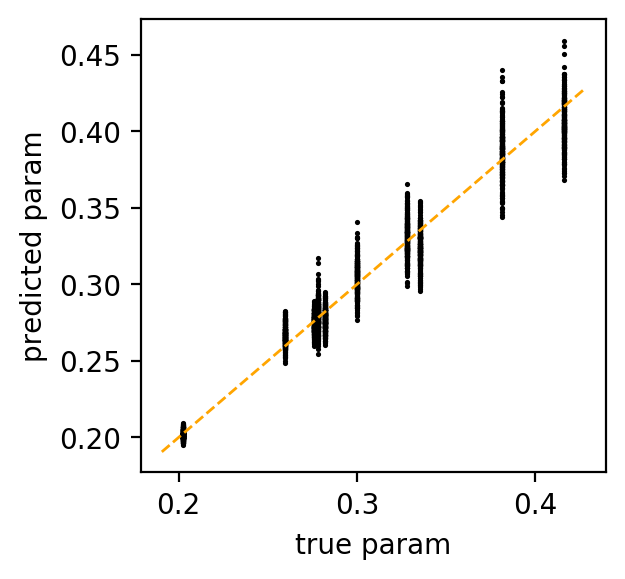

In [7]:
# check prediction
with torch.no_grad():
    result = {'y': [], 'pred': []}
    for data, params in test_loader:
        result['y'].append(params[:,1].detach().cpu())
        result['pred'].append(model(data.to(device))[:,1].detach().cpu())
        
fig = plt.figure(dpi=200, figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.scatter(torch.cat(result['y']),
           torch.cat(result['pred']),
           marker=".", 
           alpha=1, 
           zorder=0, 
           color="black",
           s=3)
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, zorder=2, color="orange", linestyle='--', linewidth=1)
ax.set_xlabel("true param")
ax.set_ylabel("predicted param")
plt.show()

In [8]:
pcm = ModelPred(model, target=1)
pcm.fit(train_loader)
y_preds, y_params = pcm.predict(test_loader)
print(rmse(y_params, y_preds, 1))

0.00017281945903334072
